In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

from joblib import dump

2022-09-01 13:00:32.704366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 13:00:32.704426: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('dataset_phishing.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
# check null values

df.isnull().values.any()

False

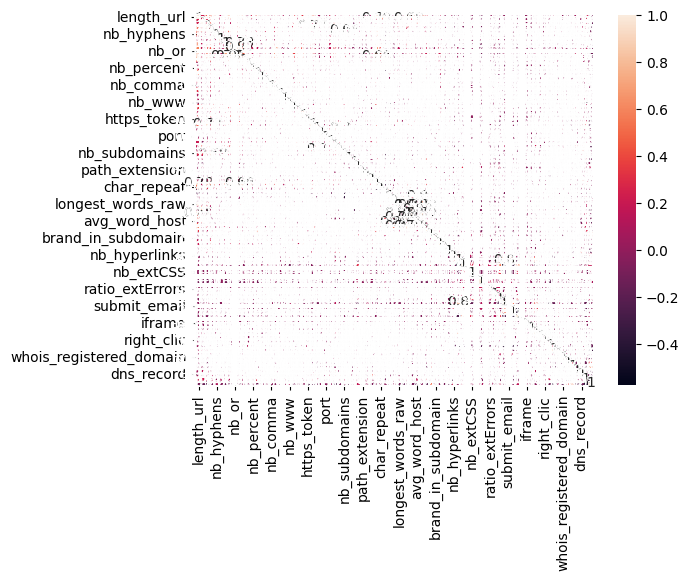

In [4]:
# Correlation matrix

dataplot = sb.heatmap(df.corr(), annot=True)
plt.show()

In [5]:
# Convert str into label - if phishing then 1, legitimate 0

df['label'] = df['status'].apply(lambda x: 1 if x == 'phishing' else 0)

In [6]:
# split data into x_feature & y_label 

x_features = df.drop(['url', 'status', 'label'], axis='columns')
y_label = df['label']

print(x_features.shape, y_label.shape)

(11430, 87) (11430,)


#### Split into train & test

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_features, y_label, test_size=0.2, random_state=42)

print(x_train.shape, x_test.shape)

(9144, 87) (2286, 87)


#### Standardize the data

In [8]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(x_train)

# Apply transform to both the training set and the test set.
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

In [27]:
# Save scaler for inference

dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

#### Apply PCA

In [9]:
# make an instance of the model

# .95 means that scikit-learn choose the minimum number 
# of principal components such that 95% of the variance is retained

pca = PCA(.95)

In [10]:
# fit training set

pca.fit(x_train_s)

PCA(n_components=0.95)

In [11]:
# apply mapping to both the training & test set

x_train_pca = pca.transform(x_train_s)
x_test_pca = pca.transform(x_test_s)

print(x_train_pca.shape, x_test_pca.shape)

(9144, 60) (2286, 60)


### 1. Decision Tree Classifier - PCA & all features

#### PCA 

In [12]:
#create object
d_tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)

# train classifier
d_tree_clf = d_tree_clf.fit(x_train_pca, y_train)

# Predict the response for test data
y_pred = d_tree_clf.predict(x_test_pca)

In [13]:
# Evaluation metrix - Accuracy & macro F1-score

acc = metrics.accuracy_score(y_test, y_pred)
macro_f1 = metrics.f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc}, Macro F1 Score: {macro_f1}")

Accuracy: 0.9146981627296588, Macro F1 Score: 0.9146895268701103


#### All features

In [14]:
#create object
d_tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=7)

# train classifier
d_tree_clf = d_tree_clf.fit(x_train_s, y_train)

# Predict the response for test data
y_pred = d_tree_clf.predict(x_test_s)

In [15]:
# Evaluation metrix - Accuracy & macro F1-score

acc = metrics.accuracy_score(y_test, y_pred)
macro_f1 = metrics.f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc}, Macro F1 Score: {macro_f1}")

Accuracy: 0.9295713035870516, Macro F1 Score: 0.9295566239408257


In [16]:
# save model file

dump(d_tree_clf, 'models/decision_tree_clf_all.joblib')

['models/decision_tree_clf_all.joblib']

### 2. Random Forest Classifier

In [17]:
# create object
rf_clf = RandomForestClassifier(n_estimators=40)

# train classifier
rf_clf.fit(x_train_s, y_train)

# pred on test data
y_pred_rf = rf_clf.predict(x_test_s)

In [18]:
# Evaluation metrix - Accuracy & macro F1-score

acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
macro_f1_rf = metrics.f1_score(y_test, y_pred_rf, average='macro')

print(f"Accuracy: {acc_rf}, Macro F1 Score: {macro_f1_rf}")

Accuracy: 0.968066491688539, Macro F1 Score: 0.9680590042703985


In [19]:
# save model file

dump(rf_clf, 'models/random_forest_clf_all.joblib')

['models/random_forest_clf_all.joblib']

### 3. Binary Classification using Neural Network

In [20]:
# Create model

model = Sequential()

model.add(Dense(300, input_dim=87, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-09-01 13:04:18.123026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 13:04:18.123069: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-01 13:04:18.123110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stardust): /proc/driver/nvidia/version does not exist
2022-09-01 13:04:18.123357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# compilation

sgd = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['acc'])

/home/manthan/manthan/pyenv/ml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [22]:
# fit the training data

model.fit(x_train_s, y_train, epochs=100, verbose=2)

Epoch 1/100
286/286 - 1s - loss: 0.4035 - acc: 0.8571 - 891ms/epoch - 3ms/step
Epoch 2/100
286/286 - 1s - loss: 0.2073 - acc: 0.9322 - 589ms/epoch - 2ms/step
Epoch 3/100
286/286 - 1s - loss: 0.1665 - acc: 0.9424 - 624ms/epoch - 2ms/step
Epoch 4/100
286/286 - 1s - loss: 0.1507 - acc: 0.9456 - 626ms/epoch - 2ms/step
Epoch 5/100
286/286 - 1s - loss: 0.1412 - acc: 0.9479 - 573ms/epoch - 2ms/step
Epoch 6/100
286/286 - 1s - loss: 0.1343 - acc: 0.9509 - 526ms/epoch - 2ms/step
Epoch 7/100
286/286 - 1s - loss: 0.1290 - acc: 0.9530 - 542ms/epoch - 2ms/step
Epoch 8/100
286/286 - 1s - loss: 0.1246 - acc: 0.9542 - 651ms/epoch - 2ms/step
Epoch 9/100
286/286 - 1s - loss: 0.1206 - acc: 0.9559 - 538ms/epoch - 2ms/step
Epoch 10/100
286/286 - 1s - loss: 0.1169 - acc: 0.9577 - 526ms/epoch - 2ms/step
Epoch 11/100
286/286 - 1s - loss: 0.1137 - acc: 0.9591 - 597ms/epoch - 2ms/step
Epoch 12/100
286/286 - 1s - loss: 0.1106 - acc: 0.9601 - 592ms/epoch - 2ms/step
Epoch 13/100
286/286 - 1s - loss: 0.1078 - acc: 0

In [23]:
y_pred_nn = model.predict(x_test_s)

72/72 [==============================] - 0s 2ms/step


In [35]:
y_pred_nn

array([[3.3272111e-06],
       [1.8314609e-02],
       [1.1084139e-03],
       ...,
       [9.9999696e-01],
       [2.1619041e-07],
       [9.9989045e-01]], dtype=float32)

In [24]:
y_pred_thresh = []
for value in y_pred_nn:
    if value > 0.5:
        y_pred_thresh.append(1)
    else:
        y_pred_thresh.append(0)

In [25]:
# Evaluation metrix - Accuracy & macro F1-score

acc_nn = metrics.accuracy_score(y_test, y_pred_thresh)
macro_f1_nn = metrics.f1_score(y_test, y_pred_thresh, average='macro')

print(f"Accuracy: {acc_nn}, Macro F1 Score: {macro_f1_nn}")

Accuracy: 0.9676290463692039, Macro F1 Score: 0.9676248583764583


In [26]:
# save the model

model.save('models/nn_clf_all.h5')

In [ ]:
# load model and predict

# from joblib import load
# clf = load('models/random_forest_clf_all.joblib')

# from tensorflow.keras.models import load_model
# model = load_model('models/nn_clf_all.h5')